In [31]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as mpatches

# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 5))
mpl.rc('image', cmap='gray')

In [32]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience

import pims
import trackpy as tp
import scipy as sp
import cv2

In [33]:
import skimage
from skimage import morphology, util
from skimage import filters
from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray

In [110]:
@pims.pipeline
def gray(image):
    return image[:, :]  

frames = gray(pims.open(r"C:\Users\PARITOSHCHANDRASHEKH\Desktop\Work\Ghanim\280um2.33vpm15x7.5um_2.tif"))
len(frames)

TiffPages: invalid page offset 15439408


475

In [111]:
print(frames)

(TiffStack_tifffile,) processed through proc_func. Original repr:
    <Frames>
    Source: C:\Users\PARITOSHCHANDRASHEKH\Desktop\Work\Ghanim\280um2.33vpm15x7.5um_2.tif
    Length: 475 frames
    Frame Shape: (168, 192)
    Pixel Datatype: uint8


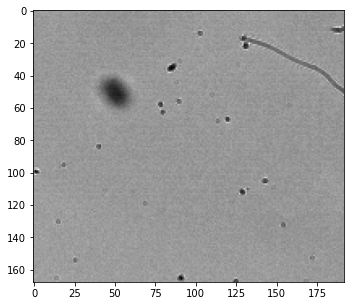

In [112]:
plt.imshow(frames[200]); 

In [113]:
f = tp.locate(frames[235], 61, invert=True)
f.head()

,y,x,mass,size,ecc,signal,raw_mass,ep,frame
0,48.399166,44.820181,12868.70410,5.138813,0.274548,116.963200,352545.0,NaN,235
1,119.506215,139.192834,4390.93614,20.081478,0.189663,50.913393,344840.0,NaN,235


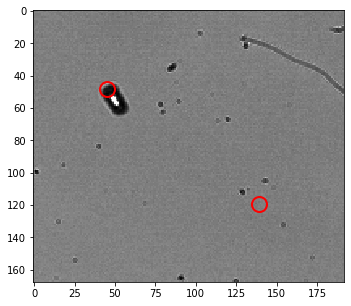

<AxesSubplot:>

In [114]:
tp.annotate(f,frames[250])

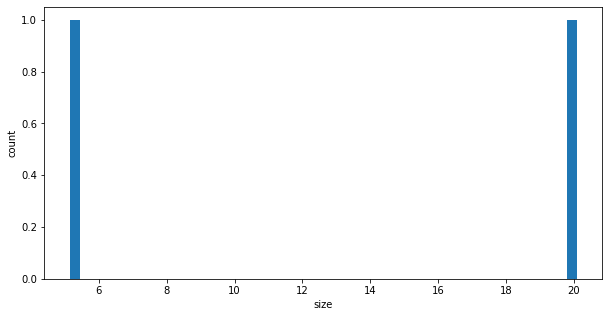

In [115]:
fig, ax = plt.subplots()
ax.hist(f['size'], bins = 50)

# Optionally, label the axes.
ax.set(xlabel='size', ylabel='count');

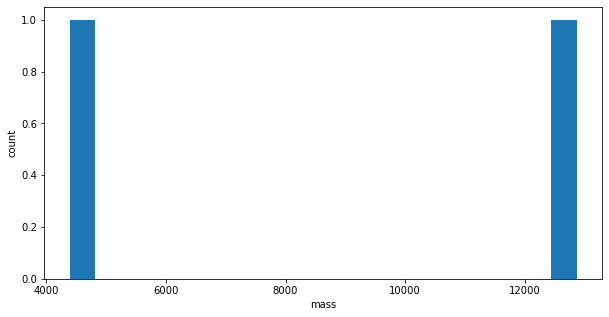

In [116]:
fig, ax = plt.subplots()
ax.hist(f['mass'], bins=20)

# Optionally, label the axes.
ax.set(xlabel='mass', ylabel='count');

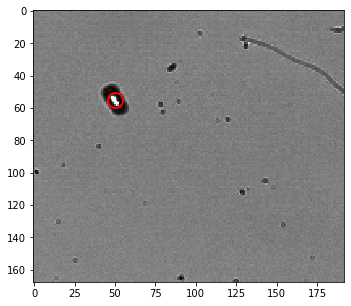

In [117]:
f = tp.locate(frames[250], 51, invert=True, minmass=8000)
tp.annotate(f,frames[250]);

In [118]:
f = tp.batch(frames[:len(frames)], 51, minmass=8000, invert=True);

Frame 474: 0 features


In [119]:
t = tp.link(f, 5, memory=95)

Frame 463: 1 trajectories present.


In [120]:
t.head()

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
0,37.619798,40.377525,13595.251870,5.802397,0.212264,90.119037,249881.0,NaN,0,0
1,37.526938,40.142363,13649.327962,5.784047,0.214266,90.148456,249619.0,NaN,1,0
2,37.309023,39.884491,13695.236021,5.750395,0.217422,91.846650,249408.0,NaN,2,0
3,37.086142,39.661983,13517.167584,5.701704,0.217793,91.029524,250358.0,NaN,3,0
4,36.891989,39.377252,13434.207727,5.660977,0.215124,91.294184,249806.0,NaN,4,0


In [124]:
t1 = tp.filter_stubs(t, 110)
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())

Before: 4
After: 1


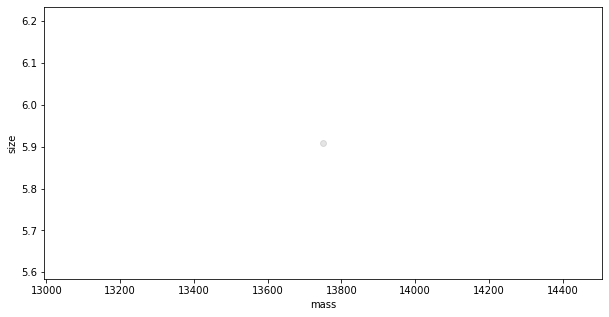

In [125]:
plt.figure()
tp.mass_size(t1.groupby('particle').mean());

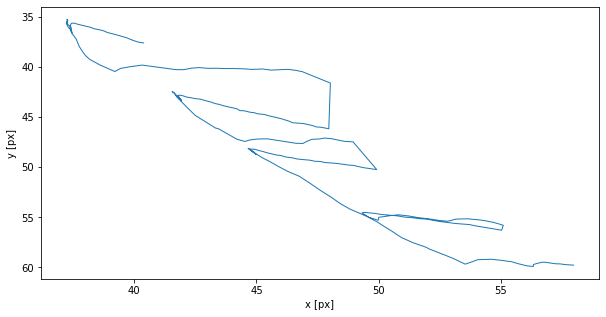

In [126]:
plt.figure()
tp.plot_traj(t1);

In [127]:
p = []
for idx in range(len(frames)):
    
    ret,thresh1 = cv2.threshold(frames[idx],55,255,cv2.THRESH_BINARY)
    p.append(thresh1)

x= 43.12 y= 43.42 area= 100


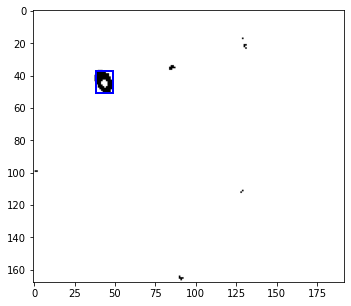

In [129]:
slim=10
llim=3000
con = 2
img_example = p[125]

label_image = skimage.measure.label(img_example,connectivity=con,background=-1)

fig, ax = plt.subplots()
ax.imshow(img_example)

yp=[]
xp=[]
area=[]
bod=[]
ed=[]

for region in skimage.measure.regionprops(label_image, intensity_image=img_example):
    if region.area < slim or region.area > llim:
        continue
    if region.mean_intensity > 1:
            continue   
    if region.centroid[0] < 700 and region.area < 5:
        continue
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='blue', linewidth=2)

    ax.add_patch(rect)
    print('x=',region.centroid[1],'y=',region.centroid[0],'area=',region.area)
     
    bod.append(region.coords)
    yp.append(region.centroid[0])
    xp.append(region.centroid[1])
    area.append(region.area)
    ed.append(region.equivalent_diameter)

In [130]:
f = pd.DataFrame()

for num, img in enumerate(p):
    label_image = skimage.measure.label(img,connectivity=con,background=-1)
    
    yp=[]
    xp=[]
    area=[]
  
    for region in skimage.measure.regionprops(label_image, intensity_image=img):
        if region.area < slim or region.area > llim:
            continue
        if region.mean_intensity > 1:
            continue
        if region.centroid[0] < 700 and region.area < 5:
            continue
        yp.append(region.centroid[0])
        xp.append(region.centroid[1])
        area.append(region.area)

    for i in range(len(yp)):
        f = f.append([{'y': yp[i],'x': xp[i], 'frame': num,'area':area[i]},])

In [131]:
f

,y,x,frame,area
0,37.481481,40.580247,0,81
0,37.192771,40.168675,1,83
0,37.164706,39.894118,2,85
0,37.000000,39.647727,3,88
0,36.755319,39.276596,4,94
...,...,...,...,...
0,64.629630,63.222222,456,54
0,64.760870,63.543478,457,46
0,64.944444,63.555556,458,36
0,65.217391,64.086957,459,23


In [97]:
#f = f.query('frame > 20')

Text(0, 0.5, 'Area')

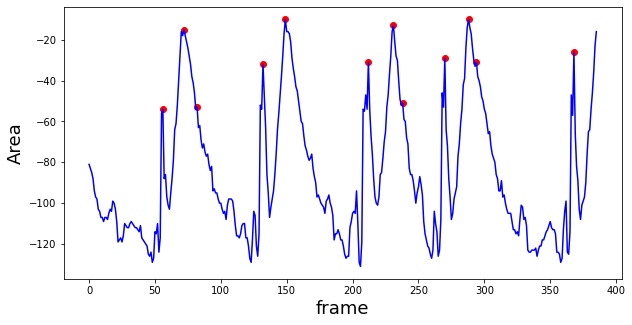

In [133]:
from scipy.misc import electrocardiogram
from scipy.signal import find_peaks

peaks, _ = find_peaks(-f['area'].values,height=-60,distance=5)
plt.plot(-f['area'].values,color='b')
plt.scatter(peaks, -f['area'].values[peaks],color='r')
plt.xlabel('frame', fontsize = 18)
plt.ylabel('Area',fontsize=18)
#plt.xlim(50,350)
#plt.ylim(-1100, -350)

In [134]:
peaks

array([ 56,  72,  82, 132, 149, 212, 231, 238, 270, 288, 294, 368],
      dtype=int64)

In [135]:
len(peaks)

12

In [136]:
peak_positions=[]
for i in peaks:
    peak_positions.append(f.iloc[i][["x","y"]].values)

In [137]:
peak_positions=np.array(peak_positions)

In [592]:
#dis_array3_4=[]
#for i in range(len(peak_positions)-1):
    #dis_array3_4.append(np.linalg.norm(peak_positions[0]-peak_positions[i+1], ord=2))

In [50]:
dis_array22_70_1=[]
for i in range(len(peak_positions)-1):
    dis_array22_70_1.append(np.linalg.norm(peak_positions[0]-peak_positions[i+1], ord=2))

In [91]:
dis_array22_70_2=[]
for i in range(len(peak_positions)-1):
    dis_array22_70_2.append(np.linalg.norm(peak_positions[0]-peak_positions[i+1], ord=2))

In [144]:
dis_array22_70_3=[]
for i in range(len(peak_positions)-1):
    dis_array22_70_3.append(np.linalg.norm(peak_positions[0]-peak_positions[i+1], ord=2))

In [191]:
dis_array22_70_4=[]
for i in range(len(peak_positions)-1):
    dis_array22_70_4.append(np.linalg.norm(peak_positions[0]-peak_positions[i+1], ord=2))

## 70 Micron
#### 33vpm15umx7.5um_1



In [53]:
dis_array22_70_1

[2.013925370872971,
 6.289037521486454,
 9.744049069617095,
 14.753315616029418,
 14.107045219068215,
 15.914896686577917,
 18.475814243526,
 22.422911995498602,
 27.605841910667674,
 28.476397482086092,
 30.536380772855775,
 34.30978290949178,
 35.51481404444882,
 36.334928200137156,
 42.18923593777303,
 45.00808628006036,
 51.7189683160303,
 55.08389039421306]

In [54]:
dis_array22_70_1_np = np.array([2.013925370872971,
 6.289037521486454,
 9.744049069617095,
 14.753315616029418,
 14.107045219068215,
 15.914896686577917,
 18.475814243526,
 22.422911995498602,
 27.605841910667674,
 28.476397482086092,
 30.536380772855775,
 34.30978290949178,
 35.51481404444882,
 36.334928200137156,
 42.18923593777303,
 45.00808628006036,
 51.7189683160303,
 55.08389039421306])*2
dis_array22_70_1_np

array([  4.02785074,  12.57807504,  19.48809814,  29.50663123,
        28.21409044,  31.82979337,  36.95162849,  44.84582399,
        55.21168382,  56.95279496,  61.07276155,  68.61956582,
        71.02962809,  72.6698564 ,  84.37847188,  90.01617256,
       103.43793663, 110.16778079])

In [55]:
dis_array22_70_1_pc = []
for i in range(len(peak_positions)-1):
    dis_array22_70_1_pc.append(np.linalg.norm(peak_positions[i]-peak_positions[i+1], ord=2))

In [56]:
dis_array22_70_1_pc = [2.013925370872971,
 4.27870774280912,
 3.47208588414313,
 5.024753204054947,
 0.6799713150887536,
 1.809975196454577,
 2.5776899417074652,
 4.04381252724409,
 5.220307508359876,
 1.0231500967013165,
 2.0623299126828787,
 3.7870419147904935,
 1.2329955839473288,
 0.8346633407347409,
 5.857507957842343,
 2.8333567663779773,
 6.760678511583606,
 3.3946558100979707]

In [92]:
dis_array22_70_2

[22.812858913917253,
 30.548086392181172,
 27.68147627015119,
 37.85649518919427,
 47.39862848388632,
 56.65606333781695,
 79.7852896527501,
 76.86536124722802,
 86.49271240702357,
 103.72058914685257,
 113.51824709941612,
 107.34980653784187,
 122.53864341963032]

In [93]:
dis_array22_70_2_np = np.array([22.812858913917253,
 30.548086392181172,
 27.68147627015119,
 37.85649518919427,
 47.39862848388632,
 56.65606333781695,
 79.7852896527501,
 76.86536124722802,
 86.49271240702357,
 103.72058914685257,
 113.51824709941612,
 107.34980653784187,
 122.53864341963032])*2
dis_array22_70_2_np

array([ 45.62571783,  61.09617278,  55.36295254,  75.71299038,
        94.79725697, 113.31212668, 159.57057931, 153.73072249,
       172.98542481, 207.44117829, 227.0364942 , 214.69961308,
       245.07728684])

In [94]:
dis_array22_70_2_pc = []
for i in range(len(peak_positions)-1):
    dis_array22_70_2_pc.append(np.linalg.norm(peak_positions[i]-peak_positions[i+1], ord=2))

In [57]:
dis_array22_70_2_pc = [22.812858913917253,
 7.737179607332238,
 2.9025719432727226,
 10.196506549939523,
 9.6511090611985,
 9.271355118251746,
 23.207682235056982,
 2.9392014924881207,
 9.644283413400972,
 17.35402302667893,
 9.913633734787863,
 6.174585012319495,
 15.24395412463366]

In [145]:
dis_array22_70_3

[8.562776513498072,
 5.60079614870424,
 7.46182317600856,
 15.966564594746124,
 18.13010453333712,
 27.193004162690517,
 38.16345286696039,
 46.71402406552984,
 45.39996826758242,
 53.77918418315313,
 67.2251816081784,
 63.86340025587331,
 63.41491653867116,
 84.8961053278028,
 90.14712674765191]

In [146]:
dis_array22_70_3_np = np.array([8.562776513498072,
 5.60079614870424,
 7.46182317600856,
 15.966564594746124,
 18.13010453333712,
 27.193004162690517,
 38.16345286696039,
 46.71402406552984,
 45.39996826758242,
 53.77918418315313,
 67.2251816081784,
 63.86340025587331,
 63.41491653867116,
 84.8961053278028,
 90.1471267476519])*2
dis_array22_70_3_np

array([ 17.12555303,  11.2015923 ,  14.92364635,  31.93312919,
        36.26020907,  54.38600833,  76.32690573,  93.42804813,
        90.79993654, 107.55836837, 134.45036322, 127.72680051,
       126.82983308, 169.79221066, 180.2942535 ])

In [52]:
dis_array22_70_3_pc = []
for i in range(len(peak_positions)-1):
    dis_array22_70_3_pc.append(np.linalg.norm(peak_positions[i]-peak_positions[i+1], ord=2))

In [192]:
dis_array22_70_4

[6.314502074262273,
 14.011552979406146,
 20.092299596950603,
 36.248087602635046,
 31.058783958377248,
 35.81162625476822,
 46.382353721099555,
 52.116120642369424,
 54.760850858383186,
 57.54787986622066,
 66.53772776862864]

In [193]:
dis_array22_70_4_np = np.array([6.314502074262273,
 14.011552979406146,
 20.092299596950603,
 36.248087602635046,
 31.058783958377248,
 35.81162625476822,
 46.382353721099555,
 52.116120642369424,
 54.760850858383186,
 57.54787986622066,
 66.53772776862864])*2
dis_array22_70_4_np

array([ 12.62900415,  28.02310596,  40.18459919,  72.49617521,
        62.11756792,  71.62325251,  92.76470744, 104.23224128,
       109.52170172, 115.09575973, 133.07545554])

In [54]:
dis_array22_70_4_pc = []
for i in range(len(peak_positions)-1):
    dis_array22_70_4_pc.append(np.linalg.norm(peak_positions[i]-peak_positions[i+1], ord=2))

In [55]:
dis_array22_70_4_pc

[2.4916742299702115,
 10.429549085436076,
 7.698333589197416,
 1.5702100377848283,
 5.602596215798345,
 10.513533051818214,
 7.483098113055486,
 3.0926860652045467,
 5.275456474324529,
 1.5188366260538817,
 2.042309888295781,
 8.291374414050662,
 7.534085293011777,
 2.7781987743413916]

### 280 Micron

In [106]:
dis_array22_280_1=[]
for i in range(len(peak_positions)-1):
    dis_array22_280_1.append(np.linalg.norm(peak_positions[0]-peak_positions[i+1], ord=2))
dis_array22_280_1

[1.5188366260538817,
 0.6147908968805045,
 7.85791755039292,
 0.34355390075831194,
 2.5895564232384993]

In [107]:
dis_array22_280_1_np = np.array([2.4916742299702115,
 10.241162149004568,
 2.8987188456605875,
 3.8881058466153484,
 6.365660345770267,
 16.62001855980569,
 9.78229112109052,
 9.2495263013298,
 12.935902888085355,
 12.335043099662581,
 12.83452286607396,
 20.017043510263097,
 13.270420262720114,
 11.30949709450535])*2
dis_array22_280_1_np

array([ 4.98334846, 20.4823243 ,  5.79743769,  7.77621169, 12.73132069,
       33.24003712, 19.56458224, 18.4990526 , 25.87180578, 24.6700862 ,
       25.66904573, 40.03408702, 26.54084053, 22.61899419])

In [67]:
dis_array22_280_1_pc = []
for i in range(len(peak_positions)-1):
    dis_array22_280_1_pc.append(np.linalg.norm(peak_positions[i]-peak_positions[i+1], ord=2))
dis_array22_280_1_pc

[2.4916742299702115,
 10.429549085436076,
 7.698333589197416,
 1.5702100377848283,
 5.602596215798345,
 10.513533051818214,
 7.483098113055486,
 3.0926860652045467,
 5.275456474324529,
 1.5188366260538817,
 2.042309888295781,
 8.291374414050662,
 7.534085293011777,
 2.7781987743413916]

In [138]:
dis_array22_280_2=[]
for i in range(len(peak_positions)-1):
    dis_array22_280_2.append(np.linalg.norm(peak_positions[0]-peak_positions[i+1], ord=2))
dis_array22_280_2

[6.991027955836449,
 4.630750823454223,
 4.478695005791755,
 9.400231296223334,
 7.544468109580771,
 18.767237539834777,
 16.17455256632337,
 12.468162440001898,
 30.41673966956683,
 28.3906049399797,
 19.78238281154109]

In [139]:
dis_array22_280_2_np = np.array([6.991027955836449,
 4.630750823454223,
 4.478695005791755,
 9.400231296223334,
 7.544468109580771,
 18.767237539834777,
 16.17455256632337,
 12.468162440001898,
 30.41673966956683,
 28.3906049399797,
 19.78238281154109])*2
dis_array22_280_2_np

array([13.98205591,  9.26150165,  8.95739001, 18.80046259, 15.08893622,
       37.53447508, 32.34910513, 24.93632488, 60.83347934, 56.78120988,
       39.56476562])

In [141]:
dis_array22_280_2_pc = []
for i in range(len(peak_positions)-1):
    dis_array22_280_2_pc.append(np.linalg.norm(peak_positions[i]-peak_positions[i+1], ord=2))
dis_array22_280_2_pc

[6.991027955836449,
 2.4618360712884786,
 5.02401291747835,
 9.747984567334933,
 2.920226211071553,
 11.34867802992332,
 2.69354404184879,
 3.7072208067534014,
 17.95748877464657,
 2.0263226176195124,
 8.620812017575446]

In [59]:
cycle_array=[]
for i in range(len(peak_positions)-1):
    cycle_array.append(i)
    
cycle_array

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

Text(0.5, 1.0, '1x1x1 cumulative particle displacement, $E=2.333 V/μm$')

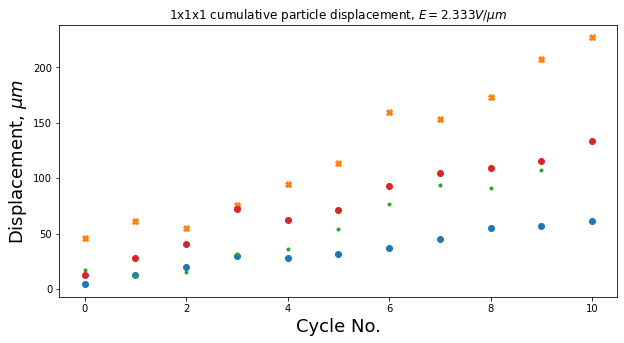

In [202]:

plt.plot(cycle_array[:11], dis_array22_70_1_np[:11], 'o', label='inline')
plt.plot(cycle_array[:11], dis_array22_70_2_np[:11], 'X', label='inline')
plt.plot(cycle_array[:11], dis_array22_70_3_np[:11], '.', label='inline')
plt.plot(cycle_array[:11], dis_array22_70_4_np[:11], 'o', label='inline')
plt.xlabel('Cycle No.', fontsize=18)
plt.ylabel(r'Displacement, $μm$', fontsize=18)
plt.title('1x1x1 cumulative particle displacement, $E=2.333 V/μm$')

Text(0.5, 1.0, '1x1x1 cumulative particle displacement for 280um-pm15x7.5um, $E=2.333 V/μm$')

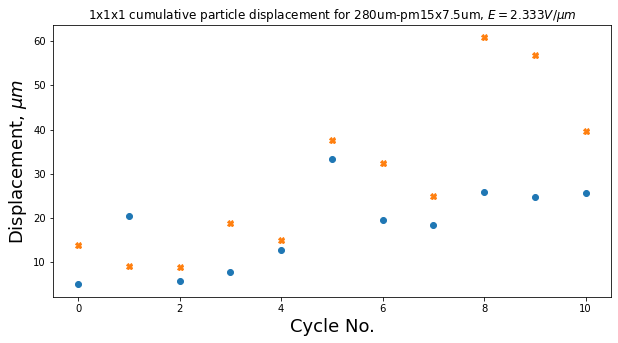

In [142]:

plt.plot(cycle_array[:11], dis_array22_280_1_np[:11], 'o', label='inline')
plt.plot(cycle_array[:11], dis_array22_280_2_np[:11], 'X', label='inline')
#plt.plot(cycle_array[:11], dis_array22_70_3_np[:11], '.', label='inline')
#plt.plot(cycle_array[:11], dis_array22_70_4_np[:11], 'o', label='inline')
plt.xlabel('Cycle No.', fontsize=18)
plt.ylabel(r'Displacement, $μm$', fontsize=18)
plt.title('1x1x1 cumulative particle displacement for 280um-pm15x7.5um, $E=2.333 V/μm$')

Text(0.5, 1.0, '1x0.5x1 cumulative particle displacement, $E=2.333 V/μm$')

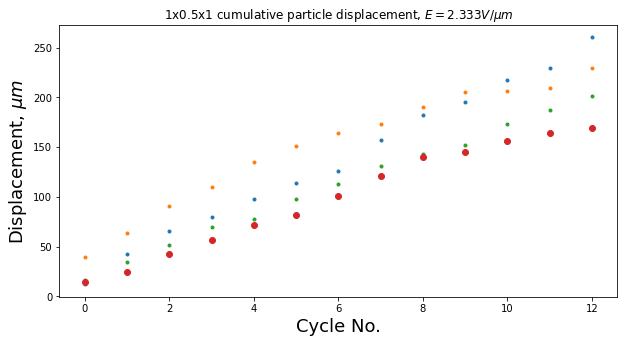

In [42]:
plt.plot(cycle_array[:13], dis_array7[:13],'.', label='inline')
plt.plot(cycle_array[:13], dis_array8[:13],'.', label='inline')
plt.plot(cycle_array[:13], dis_array9[:13],'.', label='inline')

# plt.plot(cycle_array[:15], dis_array4[:15], '*', label='inline')
# plt.plot(cycle_array[:15], dis_array5[:15], '*', label='inline')
 plt.plot(cycle_array[:15], dis_array22_70_1_np[:1], '*', label='inline')

plt.xlabel('Cycle No.', fontsize=18)
plt.ylabel(r'Displacement, $μm$', fontsize=18)
plt.title('1x0.5x1 cumulative particle displacement, $E=2.333 V/μm$')

Text(0.5, 1.0, '1x1x1 particle displacement per cycle, $E=2.333 V/μm$')

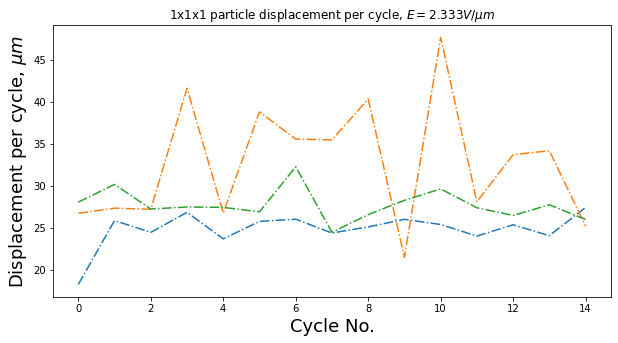

In [290]:
plt.plot(cycle_array[:15], dis_array_pc1[:15],'-.', label='inline')
plt.plot(cycle_array[:15], dis_array_pc2[:15],'-.', label='inline')
plt.plot(cycle_array[:15], dis_array_pc3[:15],'-.', label='inline')

# plt.plot(cycle_array[:25], dis_array_pc1[:25], '-*', label='inline')
# plt.plot(cycle_array[:25], dis_array_pc4[:25], '-*', label='inline')
# plt.plot(cycle_array[:25], dis_array_pc5[:25], '-*', label='inline')

plt.xlabel('Cycle No.', fontsize=18)
plt.ylabel(r'Displacement per cycle, $μm$', fontsize=18)
plt.title('1x1x1 particle displacement per cycle, $E=2.333 V/μm$')

###150 um 15 micron particles

In [602]:
dis_array6_1 = np.array([19.444390681906555,
 33.080143452594996,
 50.71103008528665,
 63.76476710077391,
 75.43796254869102,
 92.21652230619796,
 103.8160382341261,
 121.7145323363452,
 139.2677469716498,
 155.9141912615471,
 167.35559122759167,
 178.262853065224,
 192.37804278646206,
 201.7910199277135,
 211.32993850398958,
 220.2158691092949,
 232.4176673227766,
 242.73206784355514,
 250.00125594015663])*2

dis_array6_1

array([ 38.88878136,  66.16028691, 101.42206017, 127.5295342 ,
       150.8759251 , 184.43304461, 207.63207647, 243.42906467,
       278.53549394, 311.82838252, 334.71118246, 356.52570613,
       384.75608557, 403.58203986, 422.65987701, 440.43173822,
       464.83533465, 485.46413569, 500.00251188])

In [603]:
dis_array7_1 = np.array([13.363173509686996,
 27.006579945493435,
 40.45259763557602,
 60.743446410706014,
 73.80627754728496,
 92.05449731431861,
 108.26308633735452,
 123.66220959230021,
 140.24765786819458,
 148.1344299444212,
 165.34989688685582,
 174.52571782337046,
 184.54050722334648,
 193.46354137422142,
 198.65195839419184])*2

dis_array7_1

array([ 26.72634702,  54.01315989,  80.90519527, 121.48689282,
       147.61255509, 184.10899463, 216.52617267, 247.32441918,
       280.49531574, 296.26885989, 330.69979377, 349.05143565,
       369.08101445, 386.92708275, 397.30391679])

In [604]:
dis_array8_1 = np.array([14.025315612184352,
 29.10933065540238,
 42.71010462277654,
 56.418533793255506,
 70.08316380078375,
 83.47791373629792,
 99.54315796936363,
 111.68283395568022,
 124.82328697869606,
 138.80366634252687,
 153.38105473347812,
 166.8388852542998,
 179.76612422281497,
 193.30922824071422,
 205.95248179888318,
 219.34798152865514,
 231.4520079230097,
 245.007230280905,
 256.896243545901,
 271.16544980531404,
 284.20836045136934,
 296.3279258300409,
 308.6918033793842,
 321.62054148957486,
 334.38145457039195,
 347.8992844337548,
 359.0665761811278,
 371.9793077858554,
 384.33855254486207,
 395.628612631415,
 408.0888139517321,
 420.76906863401234,
 433.0197245085134,
 444.09272205630293,
 453.7179930100949])*2

dis_array8_1


array([ 28.05063122,  58.21866131,  85.42020925, 112.83706759,
       140.1663276 , 166.95582747, 199.08631594, 223.36566791,
       249.64657396, 277.60733269, 306.76210947, 333.67777051,
       359.53224845, 386.61845648, 411.9049636 , 438.69596306,
       462.90401585, 490.01446056, 513.79248709, 542.33089961,
       568.4167209 , 592.65585166, 617.38360676, 643.24108298,
       668.76290914, 695.79856887, 718.13315236, 743.95861557,
       768.67710509, 791.25722526, 816.1776279 , 841.53813727,
       866.03944902, 888.18544411, 907.43598602])

Text(0.5, 1.0, '1x1x1 cumulative particle displacement, $E=2.333 V/μm$')

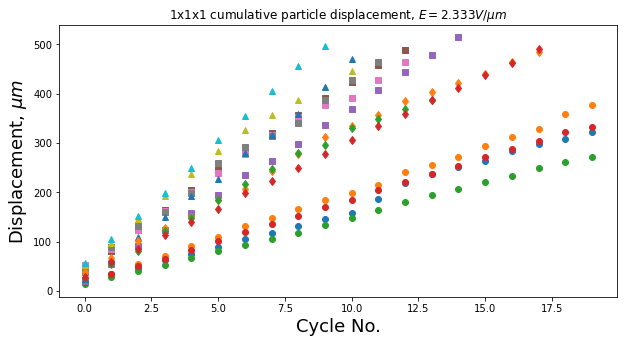

In [607]:
#plt.plot(cycle_array[:12], dis_array1_1[:12],'.', label='inline')
plt.plot(cycle_array[:20], dis_array1_2[:20],'o', label='inline')
plt.plot(cycle_array[:20], dis_array1_3[:20],'o', label='inline')
plt.plot(cycle_array[:20], dis_array1_4[:20],'o', label='inline')
plt.plot(cycle_array[:20], dis_array1_5[:20],'o', label='inline')

plt.plot(cycle_array[:15], dis_array2_1[:15],'s', label='inline')
plt.plot(cycle_array[:13], dis_array2_4[:13],'s', label='inline')
plt.plot(cycle_array[:13], dis_array2_6[:13],'s', label='inline')
plt.plot(cycle_array[:12], dis_array2_7[:12],'s', label='inline')


plt.plot(cycle_array[:11], dis_array3_1[:11],'^', label='inline')
plt.plot(cycle_array[:10], dis_array3_2[:10],'^', label='inline')
plt.plot(cycle_array[:11], dis_array3_4[:11],'^', label='inline')


plt.plot(cycle_array[:18], dis_array6_1[:18],'d', label='inline')
plt.plot(cycle_array[:14], dis_array7_1[:14],'d', label='inline')
plt.plot(cycle_array[:18], dis_array8_1[:18],'d', label='inline')

#plt.plot(cycle_array[:13], dis_array4[:13], '*', label='inline')
#plt.plot(cycle_array[:13], dis_array5[:13], '*', label='inline')
#plt.plot(cycle_array[:13], dis_array6[:13], '*', label='inline')
#plt.plot(cycle_array[:13], dis_array10[:13],'o', label='inline')
#plt.plot(cycle_array[:13], dis_array11[:13],'x', label='inline')

plt.xlabel('Cycle No.', fontsize=18)
plt.ylabel(r'Displacement, $μm$', fontsize=18)
plt.title('1x1x1 cumulative particle displacement, $E=2.333 V/μm$')

Text(0.5, 1.0, '1x1x1 particle displacement per cycle, $E=2.333 V/μm$')

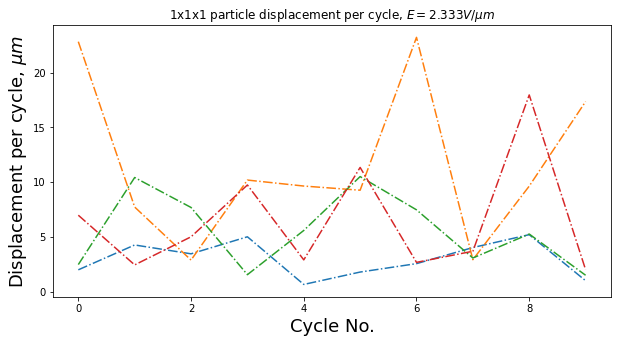

In [145]:
plt.plot(cycle_array[:10], dis_array22_70_1_pc[:10],'-.', label='inline')
plt.plot(cycle_array[:10], dis_array22_70_2_pc[:10],'-.', label='inline')

plt.plot(cycle_array[:10], dis_array22_280_1_pc[:10],'-.', label='inline')
plt.plot(cycle_array[:10], dis_array22_280_2_pc[:10],'-.', label='inline')

# plt.plot(cycle_array[:25], dis_array_pc1[:25], '-*', label='inline')
# plt.plot(cycle_array[:25], dis_array_pc4[:25], '-*', label='inline')
# plt.plot(cycle_array[:25], dis_array_pc5[:25], '-*', label='inline')

plt.xlabel('Cycle No.', fontsize=18)
plt.ylabel(r'Displacement per cycle, $μm$', fontsize=18)
plt.title('1x1x1 particle displacement per cycle, $E=2.333 V/μm$')